# Numba jit

In [1]:
!pip install numba

     |████████████████████████████████| 3.1 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 24.6 MB 153 kB/s  eta 0:00:01     |███████████████████████████▎    | 20.9 MB 11.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


В приведенном ниже коде сначала создается список из 100 000 случайных целых чисел. Затем мы применяем сортировку вставкой к списку 50 раз подряд и измеряем среднюю скорость по всем 50 операциям сортировки. 100 000 чисел - это довольно много чисел для сортировки, особенно когда наш алгоритм сортировки имеет среднюю сложность O (n²). 

In [4]:
import time
import random

num_loops = 20
len_of_list = 10000

def insertion_sort(arr):

    for i in range(len(arr)):
        cursor = arr[i]
        pos = i

        while pos > 0 and arr[pos - 1] > cursor:
            # Swap the number down the list
            arr[pos] = arr[pos - 1]
            pos = pos - 1
        # Break and do the final swap
        arr[pos] = cursor

    return arr

start = time.time()
list_of_numbers = list()
for i in range(len_of_list):
    num = random.randint(0, len_of_list)
    list_of_numbers.append(num)

for i in range(num_loops):
    result = insertion_sort(list_of_numbers)

end = time.time()

run_time = end - start

print("Average time = {}".format(run_time / num_loops))

Average time = 0.6699144005775451


Добавим в наш код только 2 дополнительные строки. Первый - это оператор импорта для импорта декоратора jit. Во-вторых, мы используем jit-декоратор в нашей функции. Применение декоратора jit к нашей функции сигнализирует numba, что мы хотим применить преобразование машинного кода к функции.

In [5]:
from numba import jit
import time
import random

num_loops = 5
len_of_list = 10000

@jit(nopython=True)
def insertion_sort(arr):

    for i in range(len(arr)):
        cursor = arr[i]
        pos = i

        while pos > 0 and arr[pos - 1] > cursor:
            # Swap the number down the list
            arr[pos] = arr[pos - 1]
            pos = pos - 1
        # Break and do the final swap
        arr[pos] = cursor

    return arr

start = time.time()
list_of_numbers = list()
for i in range(len_of_list):
    num = random.randint(0, len_of_list)
    list_of_numbers.append(num)

for i in range(num_loops):
    result = insertion_sort(list_of_numbers)

end = time.time()

run_time = end - start

print("Average time = {}".format(run_time / num_loops))

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'arr' of function 'insertion_sort'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-4f81e71e753c>", line 9:
@jit(nopython=True)
def insertion_sort(arr):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Average time = 0.21328310966491698


### Ускорение операций с Numpy
Еще одна область, в которой эффективна Numba, - это ускорение операций, выполняемых с помощью Numpy.  Сложим 3 довольно больших массива, размером с типичное изображение, а затем возвести их в квадрат с помощью функции numpy.square ().

In [6]:
import time

import numpy as np

num_loops = 50
img_1 = np.ones((1000, 1000), np.int64) * 5
img_2 = np.ones((1000, 1000), np.int64) * 10
img_3 = np.ones((1000, 1000), np.int64) * 15

def add_arrays(img_1, img_2, img_3):
    return np.square(img_1 + img_2 + img_3)

start = time.time()

for i in range(num_loops):
    result = add_arrays(img_1, img_2, img_3)

end = time.time()
run_time = end - start

print("Average time = {}".format(run_time / num_loops))

Average time = 0.014760322570800781


Но даже код Numpy не так быстр, как машинно-оптимизированный код, к которому идет Numba. Приведенный ниже код будет выполнять те же операции с массивами, что и раньше. На этот раз мы добавили декоратор векторизации прямо над функцией, сигнализируя numba, что он должен выполнить преобразование машинного кода для нашей функции.

In [7]:
from numba import vectorize, int64
import time

import numpy as np

num_loops = 50
img_1 = np.ones((1000, 1000), np.int64) * 5
img_2 = np.ones((1000, 1000), np.int64) * 10
img_3 = np.ones((1000, 1000), np.int64) * 15

@vectorize([int64(int64, int64, int64)], target="parallel")
def add_arrays(img_1, img_2, img_3):
    return np.square(img_1 + img_2 + img_3)

start = time.time()

for i in range(num_loops):
    result = add_arrays(img_1, img_2, img_3)

end = time.time()
run_time = end - start

print("Average time = {}".format(run_time / num_loops))

Average time = 0.011282901763916015


### Собственный пример ускорения с помощью numba.


In [9]:
!pip install opencv-python

     |████████████████████████████████| 49.4 MB 28.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


Декоратор для вычисления времени

In [106]:
def benchmark(func):
    import time
    
    def wrapper(*args, **kwargs):
        start = time.time()
        return_value = func(*args, **kwargs)
        end = time.time()
        print('[*] Running time: {} sec.'.format(end-start))
        return return_value
    return wrapper

        

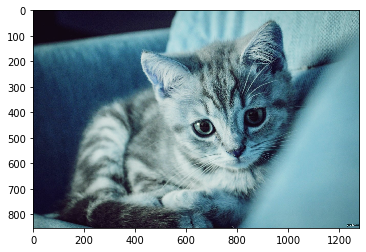

In [64]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread("./Pictures/cat.jpg")
plt.imshow(image)
pass

Вспоминаем, как вырезать окно из изображения

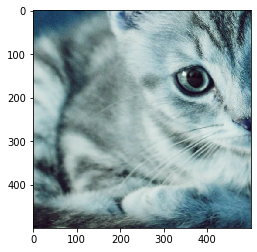

In [65]:
shift = 300
i = image[shift:shift+500,shift:shift+500]
plt.imshow(i)

pass

In [81]:
i = image[:]
j = i[1,2,1]
i.shape[0]

853

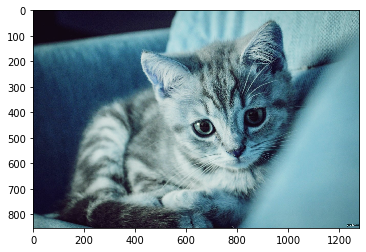

In [66]:
i = image[:]
#i[:shift,:shift] = 1.5 * i[:shift,:shift]
p = [x for x in i]
plt.imshow(p)
pass

Реализуем фильтр усредреднения по окну 5*5

In [109]:
def meanFilter(img,size=5):
    res = np.zeros_like(img)
    for x in range(img.shape[0]-size):
        for y in range(img.shape[1]-size):
            res[x+size // 2 ,y+size // 2] = [ np.mean(img[x:x+size,y:y+size,color]) for color in range(3)]
    return res


Пробуем обработать картинку без ускорения

[*] Running time: 47.69828248023987 sec.


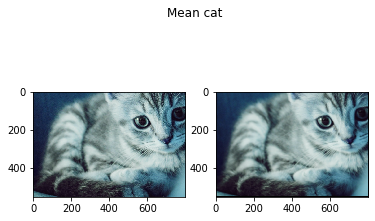

In [110]:
i = image[300:900,100:900]

@benchmark
def main():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Mean cat')
    ax1.imshow(i)
    ax2.imshow(meanFilter(i))

if __name__ == '__main__':
    main()

Теперь попытаемся ускорить процесс с помощью jit

In [111]:
from numba import jit

@jit(nopython=True)
def meanFilterSpeady(img,size=5):
    res = np.zeros_like(img)
    for x in range(img.shape[0]-size):
        for y in range(img.shape[1]-size):
            res[x+size // 2 ,y+size // 2] = [ np.mean(img[x:x+size,y:y+size,color]) for color in range(3)]
    return res

[*] Running time: 2.54939866065979 sec.


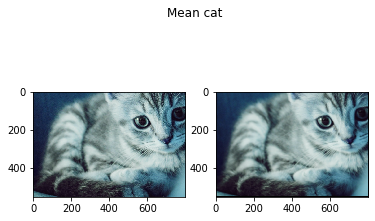

In [112]:
i = image[300:900,100:900]

@benchmark
def main():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Mean cat')
    ax1.imshow(i)
    ax2.imshow(meanFilterSpeady(i))

if __name__ == '__main__':
    main()